# 🧪 Variational Quantum Classifier with PennyLane

This Colab notebook implements a **Variational Quantum Classifier (VQC)** from scratch using PennyLane, based on the tutorial ["Building a Variational Quantum Classifier"](https://neuralsorcerer.medium.com/building-a-variational-quantum-classifier-from-scratch-a-step-by-step-guide-c8adcbf13418).

---

## Step 1: Import Libraries

We need PennyLane for quantum programming and `sklearn` for dataset generation.
We use:
- **PennyLane** for building quantum circuits and hybrid optimization
- **NumPy** for tensor manipulation
- **Scikit-learn** for generating a simple binary classification dataset
- **Matplotlib** for plotting training loss and decision boundaries

In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 58.6 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


## Step 2: Dataset Preparation

We use `make_classification` to generate a binary classification dataset with 2 informative features.

Normalize inputs so they fall within a useful range for quantum rotations.

Convert labels from {0, 1} to {-1, +1} to match the expected output of the Pauli-Z measurement (⟨Z⟩ ∈ [-1, 1]).

In [ ]:
X, y = make_classification(n_samples=100, n_features=2, n_informative=2,
                           n_redundant=0, n_clusters_per_class=1, random_state=42)
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
y = 2 * y - 1  # Convert to {-1, +1}

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

## Step 3: Quantum Device Setup
We use a simulated 2-qubit device called `default.qubit`.

In [ ]:
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

## Step 4: Define the Variational Quantum Circuit
This is the core of the quantum model:

- AngleEmbedding encodes classical inputs into quantum states using rotation gates.

- A layered structure applies RX, RY, RZ rotations to each qubit.

- CNOT gates entangle the qubits, allowing more complex transformations.

We return the expectation value of PauliZ on the first qubit, which gives a real value between -1 and +1.

In [ ]:
def variational_circuit(params, x):
    qml.AngleEmbedding(x, wires=range(n_qubits), rotation='Y')
    for layer_params in params:
        for i in range(n_qubits):
            qml.RX(layer_params[i][0], wires=i)
            qml.RY(layer_params[i][1], wires=i)
            qml.RZ(layer_params[i][2], wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i+1])
    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev)
def circuit_qnode(x, params):
    return variational_circuit(params, x)

## Step 5: Define Prediction, Loss, and Accuracy Functions

- **predict()** evaluates the circuit for a batch of inputs.

- **square_loss()** computes the mean squared error.

- **accuracy()** checks how many predictions match the true class labels.

In [ ]:
def predict(params, X):
    return np.array([circuit_qnode(x, params) for x in X])

def square_loss(params, X, Y):
    predictions = predict(params, X)
    return np.mean((predictions - Y)**2)

def accuracy(params, X, Y):
    preds = predict(params, X)
    return np.mean(np.sign(preds) == Y)

## Step 6: Training the Model
We initialize random parameters (weights of the circuit) and use GradientDescentOptimizer to minimize the loss.

The optimizer updates parameters based on gradients computed by PennyLane’s automatic differentiation.

We train over 50 epochs and track the loss

In [ ]:
num_layers = 2
params = 0.01 * np.random.randn(num_layers, n_qubits, 3, requires_grad=True)

opt = qml.GradientDescentOptimizer(stepsize=0.1)
epochs = 50
loss_history = []
accuracy_history = []

for epoch in range(epochs):
    # Update parameters using gradient descent
    params = opt.step(lambda p: square_loss(p, X_train, y_train), params)

    # Compute training loss and test accuracy
    loss_val = square_loss(params, X_train, y_train)
    acc_val = accuracy(params, X_test, y_test)

    # Store values for plotting later
    loss_history.append(loss_val)
    accuracy_history.append(acc_val)

    # Print progress
    print(f"Epoch {epoch+1:>2}: Loss = {loss_val:.4f}, Test Acc = {acc_val:.2f}")

Epoch  1: Loss = 1.8879, Test Acc = 0.30
Epoch  2: Loss = 1.8804, Test Acc = 0.30
Epoch  3: Loss = 1.8710, Test Acc = 0.30
Epoch  4: Loss = 1.8589, Test Acc = 0.30
Epoch  5: Loss = 1.8431, Test Acc = 0.30
Epoch  6: Loss = 1.8223, Test Acc = 0.30
Epoch  7: Loss = 1.7952, Test Acc = 0.30
Epoch  8: Loss = 1.7599, Test Acc = 0.30
Epoch  9: Loss = 1.7151, Test Acc = 0.30
Epoch 10: Loss = 1.6594, Test Acc = 0.30
Epoch 11: Loss = 1.5926, Test Acc = 0.30
Epoch 12: Loss = 1.5155, Test Acc = 0.35
Epoch 13: Loss = 1.4306, Test Acc = 0.35
Epoch 14: Loss = 1.3411, Test Acc = 0.40
Epoch 15: Loss = 1.2510, Test Acc = 0.45
Epoch 16: Loss = 1.1639, Test Acc = 0.45
Epoch 17: Loss = 1.0822, Test Acc = 0.50
Epoch 18: Loss = 1.0076, Test Acc = 0.60
Epoch 19: Loss = 0.9405, Test Acc = 0.60
Epoch 20: Loss = 0.8809, Test Acc = 0.60
Epoch 21: Loss = 0.8281, Test Acc = 0.60
Epoch 22: Loss = 0.7816, Test Acc = 0.60
Epoch 23: Loss = 0.7408, Test Acc = 0.60
Epoch 24: Loss = 0.7049, Test Acc = 0.65
Epoch 25: Loss =

In [ ]:
final_loss = square_loss(params, X_train, y_train)
final_accuracy = accuracy(params, X_test, y_test)

print(f"\n✅ Final Training Loss: {final_loss:.4f}")
print(f"✅ Final Test Accuracy: {final_accuracy:.2f}")


✅ Final Training Loss: 0.4784
✅ Final Test Accuracy: 1.00


In [ ]:
# Choose a real input sample and trained parameters
real_input = X_test[0]  # you can pick any data point
trained_params = params  # these are your optimized weights

# ASCII circuit diagram (console)
drawn_circuit = qml.draw(circuit_qnode)
print("Quantum Classifier Circuit with Real Input:")
print(drawn_circuit(real_input, trained_params))


Quantum Classifier Circuit with Real Input:
0: ─╭AngleEmbedding(M0)──RX(0.10)───RY(-1.61)──RZ(-0.04)─╭●──RX(-0.20)──RY(1.52)──RZ(0.01)─╭●─┤  <Z>
1: ─╰AngleEmbedding(M0)──RX(-0.00)──RY(0.14)───RZ(0.01)──╰X──RX(-0.01)──RY(0.00)──RZ(0.01)─╰X─┤     

M0 = 
[ 0.83450493 -0.29414271]


(<Figure size 1200x300 with 1 Axes>, <Axes: >)

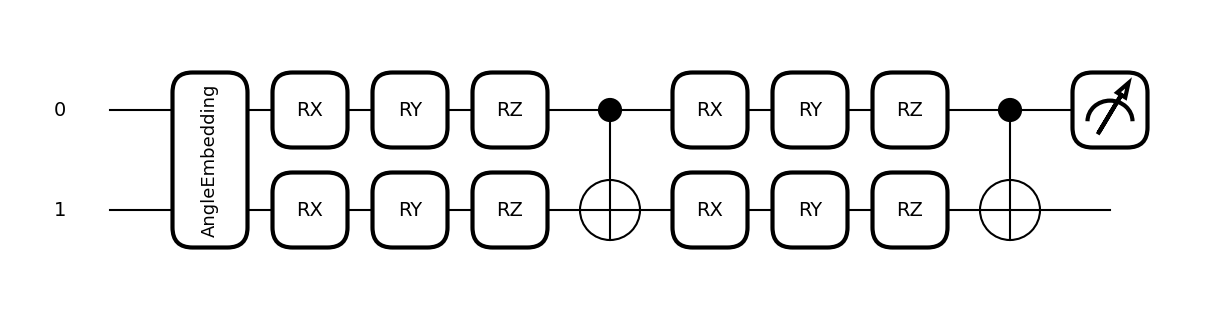

In [ ]:
qml.draw_mpl(circuit_qnode)(real_input, trained_params)

## Step 7: Plot the Training Loss
Visualize the training process to check if the model is converging.

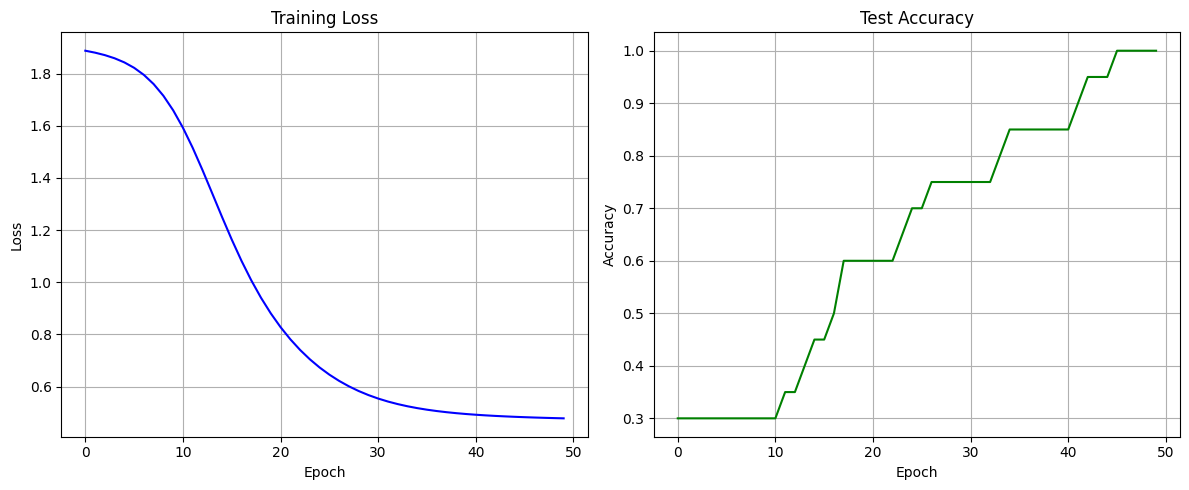

In [ ]:
# Plot both metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_history, label="Loss", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label="Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

## Step 8: Visualize the Decision Boundary
We evaluate the model across a mesh grid in 2D space and visualize the decision boundary learned by the quantum classifier.

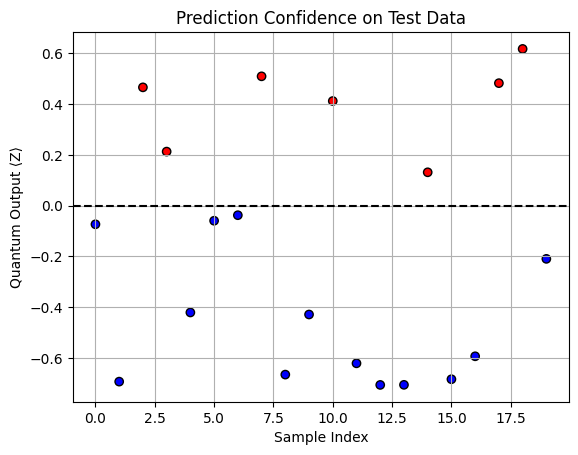

In [ ]:
predictions = predict(params, X_test)
plt.scatter(range(len(predictions)), predictions, c=y_test, cmap='bwr', edgecolors='k')
plt.axhline(0, color='black', linestyle='--')
plt.title("Prediction Confidence on Test Data")
plt.xlabel("Sample Index")
plt.ylabel("Quantum Output ⟨Z⟩")
plt.grid(True)
plt.show()